In [1]:
from os import chdir, listdir, walk, path
chdir('/home/gergely/code/fiberphotometry/')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fnmatch import fnmatch

import fiberphotometry as fp
import behavior as beh
from tdt import read_block

from datetime import datetime
import dateutil
from scipy.signal import butter, filtfilt
import scipy as sp
from scipy import io as sio #for importing .mat files

%config Completer.use_jedi = False
%matplotlib inline

## Imaging

In [2]:
# imaging data
BLOCK_PATH = '/data/gergely/invivo_DATA/fiberPhotometry/dock05b-2-210224-110203/LFPCamFP-210321-193358/'
im_data = read_block(BLOCK_PATH)
im_data.info

Found Synapse note file: /data/gergely/invivo_DATA/fiberPhotometry/dock05b-2-210224-110203/LFPCamFP-210321-193358/Notes.txt
read from t=0s to t=3654.79s


tankpath:	'/data/gergely/invivo_DATA/fiberPhotometry/dock05b-2-210224-110203'
blockname:	'LFPCamFP-210321-193358'
start_date:	datetime.datetime(2021, 3, 21, 22, 34, 3, 999999)
utc_start_time:	'22:34:03'
stop_date:	datetime.datetime(2021, 3, 21, 23, 34, 58, 794707)
utc_stop_time:	'23:34:58'
duration:	datetime.timedelta(0, 3654, 794708)
stream_channel:	0
snip_channel:	0
experiment:	'LFPCamFP'
subject:	'dock05b-2'
user:	'User'
start:	'7:34:05pm 03/21/2021'
stop:	'8:34:59pm 03/21/2021'

In [ ]:
# checking the consistency of fs

# for folder in im_folders:
#     im_dat = read_block(imaging_path+folder)
#     print(im_dat.streams['_465N'].fs)
    
# fs is consistently 1017.2526245117188

In [6]:
print(str(im_data.info['start_date']))
print(str(im_data.info['stop_date']))
print(str(im_data.info['duration']))

2021-03-21 22:34:03.999999
2021-03-21 23:34:58.794707
1:00:54.794708


/home/gergely/code/fiberphotometry/fiberphotometry.py:164: RankWarning: Polyfit may be poorly conditioned
  dFF, time_x = detrending(data, time=True)


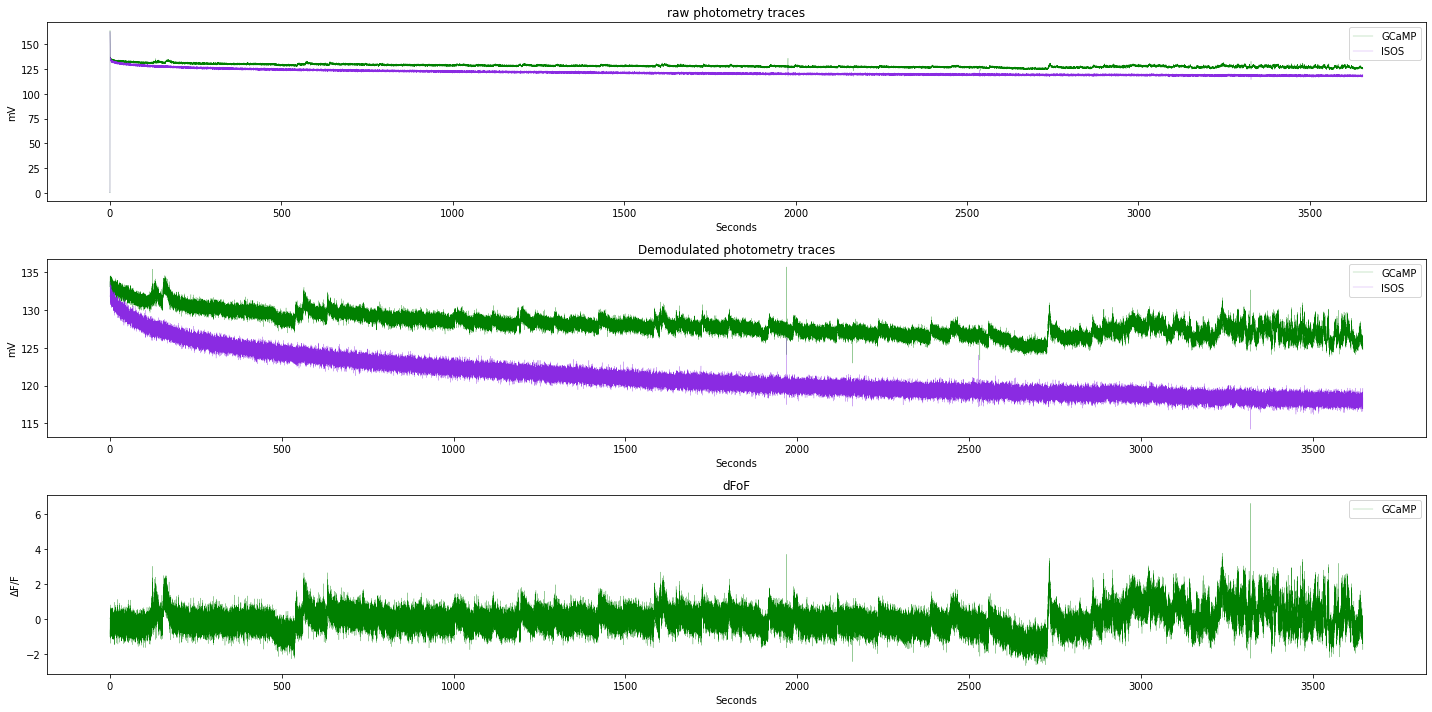

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,10))

# for ax in axes.flatten(): 
fp.plotting(im_data,ax=axes[0], kind='raw')
fp.plotting(im_data,ax=axes[1], kind='rawDemod')
fp.plotting(im_data, ax=axes[2], kind='dfof')

fig.tight_layout()

In [48]:
# reloading imaging data
im_data = read_block(BLOCK_PATH, t1=2)
len(im_data.streams['_465N'].data)

Found Synapse note file: /data/gergely/invivo_DATA/fiberPhotometry/dock05b-2-210224-110203/LFPCamFP-210321-193358/Notes.txt
read from t=2s to t=3654.79s


3715725

In [32]:
im_data.info

tankpath:	'/data/gergely/invivo_DATA/fiberPhotometry/dock05b-2-210224-110203'
blockname:	'LFPCamFP-210321-193358'
start_date:	datetime.datetime(2021, 3, 21, 22, 34, 3, 999999)
utc_start_time:	'22:34:03'
stop_date:	datetime.datetime(2021, 3, 21, 23, 34, 58, 794707)
utc_stop_time:	'23:34:58'
duration:	datetime.timedelta(0, 3654, 794708)
stream_channel:	0
snip_channel:	0
experiment:	'LFPCamFP'
subject:	'dock05b-2'
user:	'User'
start:	'7:34:05pm 03/21/2021'
stop:	'8:34:59pm 03/21/2021'

In [58]:
start = im_data.info['start_date']
stop = im_data.info['stop_date']
duration = im_data.info['duration']
fs = data.streams['_465N'].fs


In [3]:
# imaging data
imaging_path = ('/data/gergely/invivo_DATA/fiberPhotometry/dock05b-2-210224-110203/')
im_folders = beh.get_imaging_folders(imaging_path, 'LFP')
im_folders

there are 11 imaging folders


['LFPCamFP-210321-133054',
 'LFPCamFP-210321-153158',
 'LFPCamFP-210321-173258',
 'LFPCamFP-210321-193358',
 'LFPCamFP-210321-213458',
 'LFPCamFP-210321-233559',
 'LFPCamFP-210322-013658',
 'LFPCamFP-210322-033758',
 'LFPCamFP-210322-053858',
 'LFPCamFP-210322-073959',
 'LFPCamFP-210322-094058']

In [77]:
im_df = pd.DataFrame()
im_df['dff'] = fp.detrending(im_data)
im_df['time'] = pd.date_range(start=start, end=stop,
                                   periods=im_df.index.stop)
im_df.set_index('time', inplace=True)
im_df

/home/gergely/.virtualenvs/photometry/lib/python3.6/site-packages/ipykernel_launcher.py:2: RankWarning: Polyfit may be poorly conditioned
  


,dff
time,
2021-03-21 22:34:03.999999000,0.711270
2021-03-21 22:34:04.000982602,0.672500
2021-03-21 22:34:04.001966204,0.633454
2021-03-21 22:34:04.002949806,0.594120
2021-03-21 22:34:04.003933409,0.554477
...,...
2021-03-21 23:34:58.790772590,-0.868422
2021-03-21 23:34:58.791756193,-0.859038
2021-03-21 23:34:58.792739795,-0.849350


In [89]:
rolling = im_df.rolling(1000)
im_df['rolling'] = rolling.mean()
im_df

,dff,rolling
time,,
2021-03-21 22:34:03.999999000,0.711270,NaN
2021-03-21 22:34:04.000982602,0.672500,NaN
2021-03-21 22:34:04.001966204,0.633454,NaN
2021-03-21 22:34:04.002949806,0.594120,NaN
2021-03-21 22:34:04.003933409,0.554477,NaN
...,...,...
2021-03-21 23:34:58.790772590,-0.868422,-0.574305
2021-03-21 23:34:58.791756193,-0.859038,-0.575050
2021-03-21 23:34:58.792739795,-0.849350,-0.575771


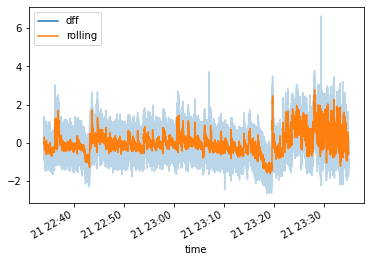

In [91]:
ax = im_df.plot(style=['-','-'])
ax.lines[0].set_alpha(0.3)

In [74]:
check_for_nan = im_df['time'].isnull().sum()
print(check_for_nan)

0


In [24]:
im_data.streams['_405N'].keys()

dict_keys(['name', 'code', 'size', 'type', 'type_str', 'ucf', 'fs', 'dform', 'start_time', 'data', 'channel'])

<AxesSubplot:title={'center':'dFoF'}, xlabel='Seconds', ylabel='$\\Delta$F/F'>

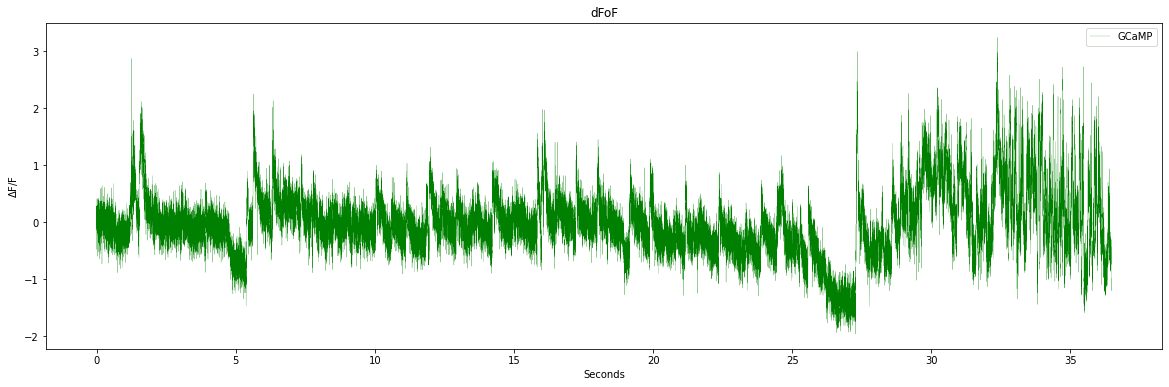

In [3]:
# plotting downsampled dff
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,6))
data = fp.artifactRemoval(im_data)
data = fp.downsampling(data,N=100)
fp.plotting(data, kind='dfof')

In [28]:
im_data = fp.artifactRemoval(im_data)
im_data.info

tankpath:	'/data/gergely/invivo_DATA/fiberPhotometry/dock05b-2-210224-110203'
blockname:	'LFPCamFP-210321-193358'
start_date:	datetime.datetime(2021, 3, 21, 22, 34, 3, 999999)
utc_start_time:	'22:34:03'
stop_date:	datetime.datetime(2021, 3, 21, 23, 34, 58, 794707)
utc_stop_time:	'23:34:58'
duration:	datetime.timedelta(0, 3654, 794708)
stream_channel:	0
snip_channel:	0
experiment:	'LFPCamFP'
subject:	'dock05b-2'
user:	'User'
start:	'7:34:05pm 03/21/2021'
stop:	'8:34:59pm 03/21/2021'

In [6]:
time = fp.resample(im_data)
len(time)

3709622

In [6]:
# fishing out start and stop times for the fiber photometry recordings
# there seems to be ~2s offset if i pull these from the imaging files
fiber_recordings = {
    "start_times":[],
    "stop_times":[]
}

mat_data = tracking_path+tracking_files[-1] #the "Notes" in the last file has it
tracking_data = beh.load_tracking(mat_data)
times = tracking_data["Note"][0] 
startlist = sorted(times[i:i+1] for i in range(0, len(times),2))
stoplist = sorted(times[i:i+1] for i in range(1, len(times),2))
for start,stop in zip(startlist, stoplist):
    start_time = start[0][0].split('at ')[1]
    stop_time = stop[0][0].split('at ')[1]
    fiber_recordings['start_times'].append(dateutil.parser.parse(start_time))
    fiber_recordings['stop_times'].append(dateutil.parser.parse(stop_time))
fiber_recordings

{'start_times': [datetime.datetime(2021, 3, 21, 13, 30, 58),
  datetime.datetime(2021, 3, 21, 15, 32, 3),
  datetime.datetime(2021, 3, 21, 17, 33, 3),
  datetime.datetime(2021, 3, 21, 19, 34, 3),
  datetime.datetime(2021, 3, 21, 21, 35, 3),
  datetime.datetime(2021, 3, 21, 23, 36, 3),
  datetime.datetime(2021, 3, 22, 1, 37, 3),
  datetime.datetime(2021, 3, 22, 3, 38, 3),
  datetime.datetime(2021, 3, 22, 5, 39, 3),
  datetime.datetime(2021, 3, 22, 7, 40, 3),
  datetime.datetime(2021, 3, 22, 9, 41, 3)],
 'stop_times': [datetime.datetime(2021, 3, 21, 14, 32, 2),
  datetime.datetime(2021, 3, 21, 16, 33, 2),
  datetime.datetime(2021, 3, 21, 18, 34, 2),
  datetime.datetime(2021, 3, 21, 20, 35, 1),
  datetime.datetime(2021, 3, 21, 22, 36, 2),
  datetime.datetime(2021, 3, 22, 0, 37, 1),
  datetime.datetime(2021, 3, 22, 2, 38, 1),
  datetime.datetime(2021, 3, 22, 4, 39, 1),
  datetime.datetime(2021, 3, 22, 6, 40, 1),
  datetime.datetime(2021, 3, 22, 8, 41, 1),
  datetime.datetime(2021, 3, 22, 1

## Tracking

In [5]:
# tracking files
tracking_path = ('/data/gergely/invivo_DATA/fiberPhotometry/tracking/dock1/overnite_rec/')
tracking_files = []
for (dirpath, dirnames, filenames) in walk(tracking_path):
    tracking_files.extend(filenames)
tracking_files.sort()
print(f"directory path:{dirpath}")
tracking_files

directory path:/data/gergely/invivo_DATA/fiberPhotometry/tracking/dock1/overnite_rec/


['2021-03-21 13-30-54.mat',
 '2021-03-21 14-30-59.mat',
 '2021-03-21 15-31-06.mat',
 '2021-03-21 16-30-59.mat',
 '2021-03-21 17-31-06.mat',
 '2021-03-21 18-30-59.mat',
 '2021-03-21 19-30-59.mat',
 '2021-03-21 20-30-59.mat',
 '2021-03-21 21-30-59.mat',
 '2021-03-21 22-30-59.mat',
 '2021-03-21 23-30-59.mat',
 '2021-03-22 00-30-59.mat',
 '2021-03-22 01-31-06.mat',
 '2021-03-22 02-30-59.mat',
 '2021-03-22 03-30-59.mat',
 '2021-03-22 04-30-59.mat',
 '2021-03-22 05-30-59.mat',
 '2021-03-22 06-30-59.mat',
 '2021-03-22 07-31-06.mat',
 '2021-03-22 08-30-59.mat',
 '2021-03-22 09-30-59.mat',
 '2021-03-22 10-30-59.mat']

In [181]:
beh_file = ('/data/gergely/invivo_DATA/fiberPhotometry/tracking/dock1/overnite_rec/2021-03-21 14-30-59.mat')
beh_data = beh.load_tracking(beh_file)
beh_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'versionName', 'mouseID', 'recorderName', 'ArduHistory', 'Note', 'ROI', 'bkImg2D', 'ROIMap', 'recordedTime', 'ROIscoreData', 'actHistPars', 'actHistData', 'actHistState', 'trackData', 'velocityData', 'moveTag', 'checkFrames', 'sleepData', 'laserEvent', 'laserInfo', 'motionPIRData', 'actHistDataPIR', 'ampLiveData', 'filename'])

In [221]:
def behavior_df_generator(beh_data):
    """Builds a dataframe from behavior data
        
    """
    
    tracking_df = pd.DataFrame(columns=['tracking_time', 'tracking_x',
                                       'tracking_y', 'velocity_speed'])


    tracking_df['tracking_time'] = beh_data['trackData'][0:,0]
    tracking_df['tracking_x'] = beh_data['trackData'][0:,1]
    tracking_df['tracking_y'] = beh_data['trackData'][0:,2]
    # tracking_df['velocity_time'] = beh_data['velocityData'][0:,0]
    tracking_df['velocity_speed'] = beh_data['velocityData'][0:,1]
    tracking_df['file'] = beh_data['filename'][0].split("\\")[3]
    tracking_df['start_time'] = beh.abs_start_time(beh_file)
    
    return tracking_df

In [244]:
# creating a BIG dataframe with the behavior values
summary_dfs = []
for i, file in enumerate(tracking_files):
    beh_data = beh.load_tracking(tracking_path+file)
    beh_df = 'df_{}'.format(i)
    beh_df = behavior_df_generator(beh_data)
    summary_dfs.append(beh_df)
    
summary_df = pd.concat(summary_dfs, ignore_index=True)

In [256]:
summary_df.head(3)
summary_df.tail(3)

,tracking_time,tracking_x,tracking_y,velocity_speed,file,start_time,clock_time
1288535,77483.709120,96.990157,170.733268,16.362732,2021-03-22 10-30-59.mat,2021-03-21 14:30:59,2021-03-22 11:02:17.709119558
1288536,77483.775028,96.370019,170.552182,9.802004,2021-03-22 10-30-59.mat,2021-03-21 14:30:59,2021-03-22 11:02:17.775028229
1288537,77483.840937,98.592398,166.948886,64.233177,2021-03-22 10-30-59.mat,2021-03-21 14:30:59,2021-03-22 11:02:17.840936899


In [252]:
# adding a column with the absolute time

start = beh.abs_start_time(tracking_path+tracking_files[0])
print(start)
time = pd.to_datetime(summary_df['tracking_time'],
               unit='s', origin=start) 
summary_df['clock_time'] = time
# time

2021-03-21 13:30:54


In [ ]:
# prototype for adding absolute time
start = beh.abs_start_time(beh_file) #first file
time = pd.to_datetime(beh_data['trackData'][0:,0].astype(np.int64),
               unit='s', origin=start) 
tracking_df['clock_time'] = time

In [289]:
# filtering velocity traces - does NOT work, most likely due to NANs
type(summary_df['velocity_speed'])
# filt_velo
def filt(x):
    b, a = butter(4, 0.8)
    return filtfilt(b,a, x)

velo_arr = np.array(summary_df['velocity_speed'])
velo_arr
filt(velo_arr)
# filt_velo = filtfilt(b,a, np.ndarray(summary_df['velocity_speed']))

array([nan, nan, nan, ..., nan, nan, nan])

In [295]:
check_for_nan = summary_df['velocity_speed'].isnull().sum()
print(check_for_nan)

23


In [ ]:
# wrangling sleep data
last_file = tracking_files[-1]
print('last file: {}'.format(last_file))
mat_path = tracking_path+last_file
beh_data = beh.load_tracking(mat_path)
sleep_data = beh_data['sleepData']

SLEEP_EVENTS ={
    'sleep_onset': sleep_data[0:,0],
    'sleep_offset': sleep_data[0:,1],
    'onset_sec' : sleep_data[0:,0]*60,
    'offset_sec' : sleep_data[0:,1]*60
} 

In [365]:
# more wrangling
SLEEP_EVENTS['onset_abs'] = pd.to_datetime(SLEEP_EVENTS['sleep_onset'],
               unit='m', origin=start) 
SLEEP_EVENTS['offset_abs'] = pd.to_datetime(SLEEP_EVENTS['sleep_offset'],
               unit='m', origin=start) 


/home/gergely/.virtualenvs/photometry/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/home/gergely/.virtualenvs/photometry/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


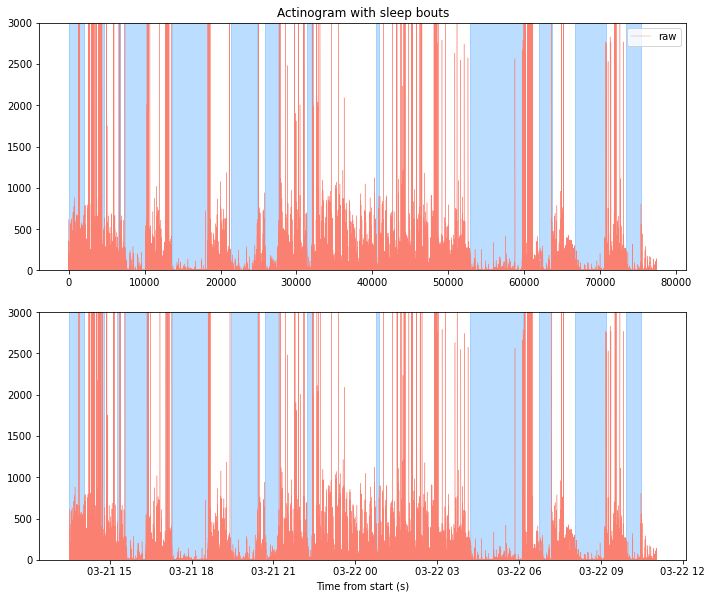

In [373]:
# plotting

fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)

ax1 = fig.add_subplot(311)
p1, = ax1.plot(summary_df['tracking_time'], summary_df['velocity_speed'],
               linewidth=.4, label='raw', color='salmon')
for i,val in enumerate(SLEEP_EVENTS['onset_sec']):
    ax1.axvspan(SLEEP_EVENTS['onset_sec'][i], SLEEP_EVENTS['offset_sec'][i],
            alpha=0.3, color='dodgerblue', label='sleep bout')
ax1.set_ylim(0,3000)
ax1.set_title('Actinogram with sleep bouts')
ax1.legend(handles=[p1], loc='upper right')

ax2 = fig.add_subplot(312)
p2, = ax2.plot(summary_df['clock_time'], summary_df['velocity_speed'],
               linewidth=.4, label='filtered', color='salmon')
for i,val in enumerate(SLEEP_EVENTS['onset_abs']):
    ax2.axvspan(SLEEP_EVENTS['onset_abs'][i], SLEEP_EVENTS['offset_abs'][i],
            alpha=0.3, color='dodgerblue')
ax2.set_ylim(0,3000)
ax2.set_xlabel('Time from start (s)')


fig.tight_layout()

In [176]:
beh_data['trackData'][0:,0]

array([0.00000000e+00, 3.79686419e-01, 7.59372838e-01, ...,
       3.59939358e+03, 3.59946197e+03, 3.59953036e+03])

In [177]:
time = pd.to_datetime(beh_data['trackData'][0:,0].astype(np.int64),
               unit='s', origin=start)

In [99]:
starttime
timestamp = datetime.timestamp(starttime)

In [ ]:
import dateutil

In [ ]:
starttime = dateutil.parser.parse('2021-03-21 13:30:54') # change hiphens to colons
starttime
# timestamp 

In [69]:
beh_data['trackData'][0:,0]

array([0.00000000e+00, 3.79686419e-01, 7.59372838e-01, ...,
       3.59939358e+03, 3.59946197e+03, 3.59953036e+03])

In [ ]:
st = starttime + datetime.timedelta(beh_data['trackData'][12,0])
str(st)

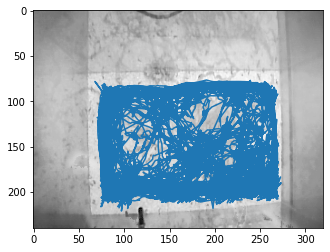

In [171]:
# tracking
beh.show_background(beh_data)
beh.show_tracking(beh_data)

In [ ]:
# total recording time - last file needed
last_file = files[-1]
print('last file: {}'.format(last_file))
mat_path = dirpath+last_file
tracking_data = beh.load_tracking(mat_path)
# converting sec to H:min:sec
print('total recording time: {}'.
      format(str(datetime.timedelta(seconds=tracking_data['recordedTime'][0][0]))))

In [ ]:
total_sleep_data = tracking_data['sleepData']
total_sleep_data
# [startpoint,endpoint,duration]=min

In [ ]:
SLEEP_EVENTS ={
    'sleep_onset':total_sleep_data[0:,0],
    'sleep_offset':total_sleep_data[0:,1],
    'onset_sec' : total_sleep_data[0:,0]*60,
    'offset_sec' : total_sleep_data[0:,1]*60
} 

SLEEP_EVENTS['onset_sec']

In [ ]:
velo = beh_data['velocityData']
velo # [time,speed,orietation]

# filtering velocity
b, a = butter(3, 0.1)
filt_velo = filtfilt(b,a, beh_data['velocityData'][0:,1])

/home/gergely/.virtualenvs/photometry/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


NameError: name 'filt_velo' is not defined

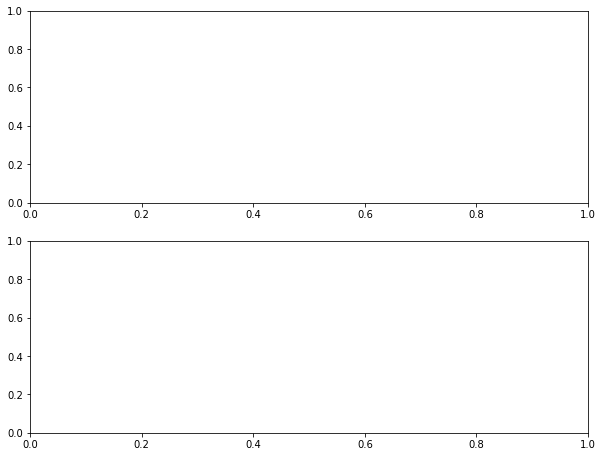

In [255]:
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)

ax1 = fig.add_subplot(311)
p1, = ax1.plot(beh_data['velocityData'][0:,0], filt_velo,
               linewidth=.4, label='filtered')
ax1.axvspan(SLEEP_EVENTS['onset_sec'][2], SLEEP_EVENTS['offset_sec'][2],
            alpha=0.25, color='dodgerblue')
ax1.legend(loc='upper right')

p1, = ax2.plot(beh_data['velocityData'][0:,0], beh_data['velocityData'][0:,1],
               linewidth=.4, label='raw')
ax2.axvspan(SLEEP_EVENTS['onset_sec'][2], SLEEP_EVENTS['offset_sec'][2],
            alpha=0.25, color='dodgerblue')
ax2.legend(loc='upper right')
fig.tight_layout()

/home/gergely/.virtualenvs/photometry/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


NameError: name 'decimatedData' is not defined

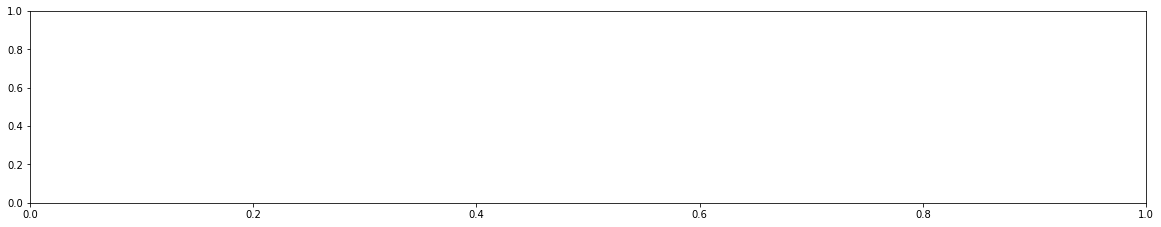

In [254]:
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(311)

ax1 = fig.add_subplot(311)
p1, = ax1.plot(decimatedData['decimatedTime'], decimatedData['decimatedSignal'],
               linewidth=.4, color='green', label='GCaMP')
for on, off in zip(data['sleepData'][0:,0], data['sleepData'][0:,1]):
    ax1.axvspan(on, off, alpha=0.25, color='dodgerblue')
ax1.set_ylabel(r'$\Delta$F/F')
ax1.set_xlabel('Seconds')
ax1.set_title('dFF with Lick Bouts')
fig.tight_layout()
fig

In [ ]:
for i in SLEEP_EVENTS['sleep_onset']:
    time = str(datetime.timedelta(minutes=i))
    print(time)

In [ ]:
velo = beh_data['velocityData']
velo



In [ ]:
tracking = beh_data['trackData']
tracking